# 自助重采样和刀切法

## 1.Bootstrap

[1] 0.7763745
[1] 0.7827419
[1] 0.1240233


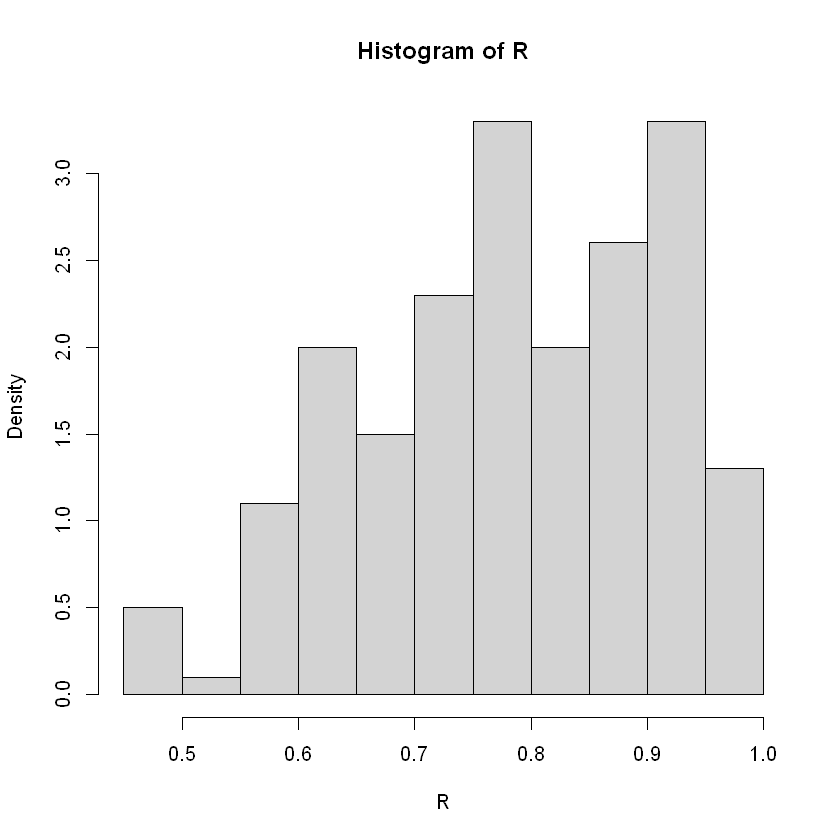

In [9]:
library(bootstrap)
data(law)

print(cor(law$LSAT, law$GPA))
#设置bootstrap循环
B <- 200 #重复抽样的次数
n <- nrow(law) #样本大小（15个）
R <- numeric(B) #储存每次循环后计算得到的相关系数
#对R的标准差进行bootstrap评估（通过计算每次抽样的标准差）
for (b in 1:B) {
  #randomly select the indices
  i <- sample(1:n, size = n, replace = TRUE)
  # 从1:n的范围内有放回地抽取n个样本
  LSAT <- law$LSAT[i] 
  GPA <- law$GPA[i]
  R[b] <- cor(LSAT, GPA)
  }
#output
print(mean(R)) # 估计值
print(se.R <- sd(R))  #多次抽样的标准差即为标准误
hist(R, prob = TRUE)

[1] 0.1232451

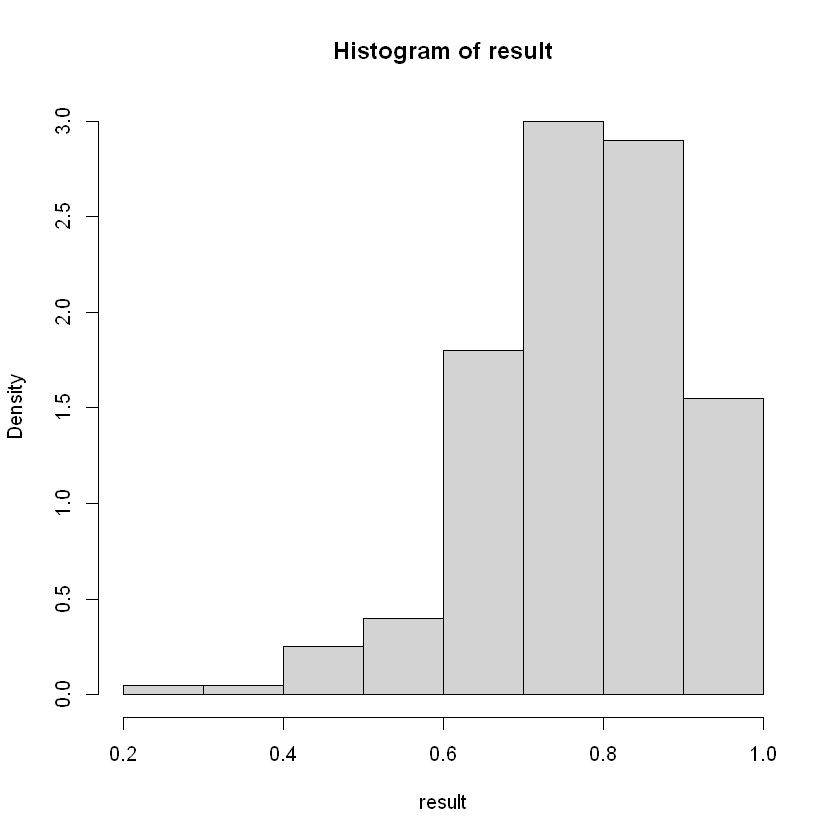

In [17]:
# 使用bootstrap函数 计算se
# bootstrap(抽取样本范围,重复次数,进行bootstrap的函数,bootstrap的数据集)
n<-15
theta<-function(x,law){cor(law[x,1],law[x,2])}
result<-bootstrap(1:n,200,theta,law)$thetastar
hist(result,prob=T)
sd(result)

In [21]:
# 计算偏差：偏差定义为bootstrap结果（多个数值）与原数据统计结果（单个数值）的均值
library(bootstrap)
data(law)
origin<-cor(law$LSAT, law$GPA)
n<-15
theta<-function(x,law){cor(law[x,1],law[x,2])}
result<-bootstrap(1:n,200,theta,law)$thetastar
se<-sd(result)
bias <- mean(result - origin)
bias

[1] 0.007007561

In [24]:
# 计算置信区间
library(boot)
data(law)
theta.boot<-function(dat,ind){
  cor(dat[ind,1],dat[ind,2])}
dat<-cbind(law$LSAT,law$GPA)
boot.obj <- boot(dat, statistic = theta.boot, R = 2000) # R为重复次数
print(boot.obj)
print(boot.ci(boot.obj,type = c("basic", "norm", "perc")))



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = dat, statistic = theta.boot, R = 2000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.7763745 -0.01048444   0.1341324
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot.obj, type = c("basic", "norm", "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.5240,  1.0498 )   ( 0.5918,  1.1088 )   ( 0.4440,  0.9610 )  
Calculations and Intervals on Original Scale


In [28]:
# 根据定义
alpha = c(0.025,0.975)
# normal
print(boot.obj$t0+qnorm(alpha*sd(boot.obj$t)))
# basic
print(2*boot.obj$t0-quantile(boot.obj$t,rev(alpha),type = 1))
# percentile
print(quantile(boot.obj$t,alpha,type = 6))

[1] -1.9346969 -0.3463416
    97.5%      2.5% 
0.5918988 1.1087998 
     2.5%     97.5% 
0.4439806 0.9609511 


这里用了三种方法计算置信区间：basic、正态和百分数。样本相关系数分布接近正态，则正态置信区间接近百分数区间。此外还有“Better Bootstrap Confivendence Interval” 更好的bootstrap置信区间，称为BCa区间，使用偏差和偏度对百分数置信区间进行矫正。设置type="bca"即可。


In [30]:
# bootstrap t置信区间
boot.t.ci = function(x,B = 500,R = 100,level = .95,statistic){
    # B是外层重抽样次数，R是内层重抽样次数
    x = as.matrix(x)
    n = nrow(x)
    stat = numeric(B)
    se = numeric(B)
    boot.se = function(x,R,f){
        # 内层对每个bootstrap样本估计se
        x = as.matrix(x)
        m = nrow(x)
        th = replicate(R,expr = {
            i = sample(1:m,size = m,replace = TRUE)
            f(x[i,])
        })
        return(sd(th))
    }
    for (b in 1:B){
        j = sample(1:n,size = n,replace = TRUE)
        y = x[j,]
        stat[b] = statistic(y)
        se[b] = boot.se(y,R = R,f = statistic)
    }
    stat0 = statistic(x)
    t.stats = (stat - stat0)/se # t统计量的计算
    se0 = sd(stat) # bootstrap重复下的标准差的计算
    alpha = 1-level
    Qt = quantile(t.stats,c(alpha/2,1-alpha/2),type = 1)
    names(Qt) = rev(names(Qt))
    CI = rev(stat0-Qt*se0)
}

dat = cbind(patch$y,patch$z)
stat = function(dat){
    mean(dat[,1]/mean(dat[,2]))
}
ci = boot.t.ci(dat,statistic = stat,B = 2000,R = 200)
print(ci)

      2.5%      97.5% 
-0.2605155  0.4490272 


## 2.Jackknife

jacknife就是每次都抽取n-1个样本，也就是每次只剔除一个原样本。

当统计量不太平滑的时候，Jacknife有很大误差。比如说对中位数进行统计，其变化很大。在进行Jacknife之后最好再跑一次bootstrap，看看是否相差很大。
或者，In this case, when the statistic is not smooth,the delete-d jackknife (leave d observations out on each replicate) can be applied.

In [13]:
library(bootstrap)
data(law)
n <- nrow(law)
LSAT <- law$LSAT
GPA <- law$GPA
theta.hat <- cor(LSAT,GPA)
print (theta.hat)
theta.jack <- numeric(n)
for (i in 1:n)
  theta.jack[i] <-cor(LSAT[-i],GPA[-i])
print(mean(theta.jack))
bias <- (n-1) * (mean(theta.jack) - theta.hat) # 偏差
se <- sqrt((n-1) * mean((theta.jack - mean(theta.jack))^2))# 标准误

[1] 0.7763745
[1] 0.7759121


## 3.jackknife-after-bootstrap

针对每次bootstrap形成的数列向量计算jackknife的标准差，这样可以看出bootstrap若干次取样之间的差异。

In [16]:
#jackknife-after-bootstrap 
# initialize
data(law)
n <- nrow(law)
LSAT <- law$LSAT
GPA <- law$GPA
B <- 2000
theta.b <- numeric(B)
# set up storage for the sampled indices 
indices <- matrix(0, nrow = B, ncol = n)
# jackknife-after-bootstrap step 1: run the bootstrap 
for (b in 1:B) {
  i <- sample(1:n, size = n, replace = TRUE) 
  LSAT <- law$LSAT[i]
  GPA <- law$GPA[i]
  theta.b[b] <- cor(LSAT,GPA)
  #save the indices for the jackknife 
  indices[b, ] <- i
}
#jackknife-after-bootstrap to est. se(se) 
se.jack <- numeric(n)
for (i in 1:n) {
  #in i-th replicate omit all samples with x[I] 
  keep <- (1:B)[apply(indices, MARGIN = 1,FUN = function(k) {!any(k == i)})] 
  ## 根据jackknife的特性，对bootstrap抽样矩阵indices进行8次取样，每次去除存在k=I的向量。
  ## 也就是说第一次取样不能包含1，第二次不能包含2，把这些行都去掉再计算。
  se.jack[i] <- sd(theta.b[keep])
}
print(sd(theta.b))
print(sqrt((n-1) * mean((se.jack - mean(se.jack))^2)))
# 算出来分别为0.1344824和0.08545141。后者较小，表面bootstrap取样之间的variance较小。

[1] 0.1311105
[1] 0.07894544


In [ ]:
n = nrow(df) # df的行数
theta = function(x,df){cor(df$height[x],df$weight[x])}
theta.boot = bootstrap(1:n,N,theta,df)$thetastar
print(mean(theta.boot)) # bootstrap相关系数估计值
# 下面计算偏差：定义为bootstrap结果（多个数值）与原数据统计结果（单个数值）的均值
origin = cor(df$height, df$weight)
bias_bs = mean(theta.boot - origin)
print(bias_bs) # bootstrap偏差
sd_bs = sd(theta.boot)
print(sd_bs) # bootstrap标准差

In [ ]:
theta.boot = numeric(N) # 初始化 
for (b in 1:N) {
    i = sample(1:n, size = n, replace = TRUE) # 可放回抽样
    theta.boot[b] = cor(data$height[i] ,data$weight[i])
}
print(mean(theta.boot)) # bootstrap相关系数估计值
# 下面计算偏差：定义为bootstrap结果（多个数值）与原数据统计结果（单个数值）的均值
origin = cor(df$height, df$weight)
bias_bs = mean(theta.boot - origin)
print(bias_bs) # bootstrap偏差
sd_bs = sd(theta.boot)
print(sd_bs) # bootstrap标准差
rnorm()